# HABSlib + BrainOS : 102

In this second notebook, we will learn how to define a pipeline and send live data to the browser for visual inspection.

## What is a pipeline?
The building blocks of every OS are small *programs* that perform simple tasks.     
You can use these programs in isolation, giving your *input* and getting the *output*.    
But a more powerful approach is to use them in combination, as a series of steps in a *pipeline*.     
*BrainOS* does the same. It offers a series of programs you can apply to EEG data, and the ability to combine them into reproducible pipelines. *Reproducible* because the parameters for the programs you define using *HABSlib* are stored in the session you create to analyse the data.

In this lesson, you will learn how to create a pipeline session, and how to visualize its data while it unfolds, which will be useful for many practical applications.
    
Please, refer to the documentation of [HABSlib](https://olocufier.github.io/HABSlib/) for further details.

In [1]:
import nest_asyncio # to allow HABSlib to run async in a Jupyter notebook
nest_asyncio.apply()

import HABSlib as hb

/Users/do/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Login
In order to use the HABS API, you need to create a free account on habs.ai/developer.    
This provides you with the **developer IP address** you can use, and a **user ID**, which you will use for all your interaction with the APIs.

The first thing to do to start a session with the HABS BrainOS is to handshake.

In [2]:
hb.handshake(base_url="http://135.237.144.125", user_id='8d60e8693a9560ee57e8eba3')


       HUMAN        AUGMENTED        BRAIN         SYSTEMS     
   ----------------------------------------------------------- 
   ▒▒▒▒     ▒▒▒▒     ░▒▒▒▒▒░     ▒▒▒▒▒▒▒▒▒▒▒▒░   ░▒▒▒▒▒▒▒▒▒░   
   ▒▒▒▒     ▒▒▒▒    ░▒▒▒▒▒▒▒░             ░▒▒▒▒ ░▒▒▒░     ░▒░  
   ▒▒▒▒▒▒▒▒▒▒▒▒▒   ░▒▒▒▒ ▒▒▒▒░   ▒▒▒▒▒▒▒▒▒▒▒▒▒   ░▒▒▒▒▒▒▒▒▒░   
   ▒▒▒▒     ▒▒▒▒  ░▒▒▒▒   ▒▒▒▒░  ▒▒▒▒     ░▒▒▒▒ ░▒░     ░▒▒▒░  
   ▒▒▒▒     ▒▒▒▒ ░▒▒▒▒     ▒▒▒▒░ ▒▒▒▒▒▒▒▒▒▒▒▒░   ░▒▒▒▒▒▒▒▒▒░   
   ----------------------------------------------------------- 
   version: 0.1.35

Handshake (RSA) successful.
Handshake (AES) successful.


True

## Acquire data and send
For this tutorial, we use the synthetic board included in the HABSlib, which allows you to define:
- number of EEG channels ('eeg_channels')
- sampling frequency of the channels ('sampling_rate')
- level of noise ('noise' between 0, no noise, and 1)
- probability of observing a generic artifact ('artifacts')
- type of envelope modulation of the EEG (currently 'sinusoidal', at 0.1Hz, or 'random', with mean=0 var=1)
- amplitude in each of the frequency bands ('delta_amp', 'theta_amp', ...)
- some 'preset' amplitude contents for different states ('focus', 'alert', 'relaxed', 'drowsy')
- the presets can be put in a sequence to vary the signal over time
- correlation can be introduced between nearby channels ('correlation_strength')
- given that the PSD of EEG often follows a power-law relationship, we can provide its slope

As you can see, there are quite a number of options to play with even without an actual EEG device ;)

**IMPORTANT NOTE**: this EEG simulator takes the same amount of time of a user recording 20 sec during a session. You should see this output:
```
Metadata validation successful!
Connecting to the headset...
Headset connected successfully!
....                              <<<<---- these points!
Stopping data streaming...
Releasing session...
```

In [4]:
from datetime import datetime
from scipy import signal

# Pipe setup and sending data
# preprocessing setup, requires a bit of knowledge about the data to process
b_notch, a_notch = signal.iirnotch(50., 2.0, 250)
sos = signal.butter(10, [1, 40], 'bandpass', fs=250, output='sos')

session_id = hb.acquire_send_pipe(
    ## Tests ##
    # pipeline='/filtering/artifact/mean',
    # pipeline='/filtering/artifact/std',
    # pipeline='/filtering/artifact/var',
    # pipeline='/filtering/artifact/kurtosis',
    # pipeline='/filtering/artifact/skew',
    # pipeline='/filtering/artifact/ifms',
    # pipeline='/filtering/artifact/delta',
    # pipeline='/filtering/artifact/theta',
    # pipeline='/filtering/artifact/alpha',
    # pipeline='/filtering/artifact/beta',
    # pipeline='/filtering/artifact/gamma',
    # pipeline='/filtering/artifact/zerocrossing',
    # pipeline='/filtering/artifact/hjorthmobility',
    # pipeline='/filtering/artifact/hjorthcomplexity',
    # pipeline='/filtering/artifact/entropy',
    # pipeline='/filtering/artifact/fractaldim',
    # pipeline='/filtering/artifact/hurst',
    # pipeline='/filtering/artifact/correlatedim',
    # pipeline='/filtering/artifact/selfaffinity',
    # pipeline='/filtering/artifact/relative',
    # pipeline='/filtering/artifact/asymmetry',
    # pipeline='/filtering/artifact/correlation',
    pipeline='/filtering/artifact/phaselocking',
    params={ 
        # dictionary, the order does not matter, they will be called by key
        "filtering": {
            'a_notch': a_notch.tolist(),
            'b_notch': b_notch.tolist(),
            'sos': sos.tolist(),
        },
        "artifact":{},
        # "mean":{},
        # "std":{},
        # "var":{},
        # "kurtosis":{},
        # "skew":{},
        # "ifms":{},
        # "delta":{},
        # "theta":{},
        # "alpha":{},
        # "beta":{},
        # "gamma":{},
        # "zerocrossing":{},
        # "hjorthmobility":{},
        # "hjorthcomplexity":{},
        # "entropy":{},
        # "fractaldim":{},
        # "hurst":{},
        # "correlatedim":{},
        # "selfaffinity":{},
        # "relative":{'band': 'alpha'},
        # "asymmetry":{'band':'alpha', 'channelA':0, 'channelB':2},
        # "correlation":{'band':'alpha', 'channelA':0, 'channelB':2},
        "phaselocking":{'band':'alpha', 'channelA':0, 'channelB':2},
    },
    user_id='8d60e8693a9560ee57e8eba3', 
    date=datetime.today().strftime('%Y-%m-%d'), 

    board="SYNTHETIC",
    extra={
        "eeg_channels": 4,
        "sampling_rate": 250,
        "noise": 1,
        "artifacts": 0.001,
        "modulation_type": 'random',
        "preset": 'drowsy', # None, # 'focus', 'alert', 'relaxed', 'drowsy'
        "sequence": None, # [("focus", 20), ("relaxed", 20)],
        "correlation_strength": 0.5,
        "power_law_slope": 0.8
    },
    serial_number="",     
    stream_duration=10, # 10 sec
    buffer_duration=5, # 5 sec epoch
    session_type="phaselocking test", 
    tags=['Happy']
)
print("this session:", session_id)

{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '2024-08-13', 'session_type': 'phaselocking test', 'session_tags': ['Happy']}
Metadata validation successful!
Session successfully created.

Session initialized. You can visualize it here:
  https://habs.ai/bos/live.html?session_id=66bb878d48be06d8ced5142c 

Connecting to the headset...
Headset connected successfully!
..
Stopping data streaming...
Releasing session...
this session: 66bb878d48be06d8ced5142c


## Take your data
Now copy the session_id of the session you just created and paste it 

In [5]:
import numpy as np

results = hb.get_data_by_session(user_id='8d60e8693a9560ee57e8eba3', session_id='669a7632cc485c74bb951179')
data = np.array(results)
print(data.shape)
print(data) 

Retrieved data successfully.
(16, 2500)
[[ 6.26602459e-02 -1.20449688e+00 -2.89793954e+00 ... -1.25758394e+01
  -6.28826696e+00 -1.42663402e+01]
 [ 6.63948147e-01  8.19309899e-01 -2.12398593e+00 ... -5.37823154e+00
  -3.97781313e+00 -6.21453114e+00]
 [-1.45824698e+00 -2.95069224e+00 -2.98052300e+00 ...  2.22814860e-02
  -3.49824881e+00 -7.84307951e-01]
 ...
 [ 1.32808234e+02 -1.52920471e+02  1.84907002e+02 ...  1.60885154e+01
   3.34069170e+01  7.29589942e+02]
 [ 4.43788791e+01  1.19491150e+02  4.85415719e+02 ...  3.86251802e+01
   1.63736979e+02  2.04116047e+02]
 [ 7.01969298e+01  2.46239435e+02  4.31215295e+02 ... -5.26010691e+01
   3.17122067e+02  2.04562948e+02]]


### Now plot it

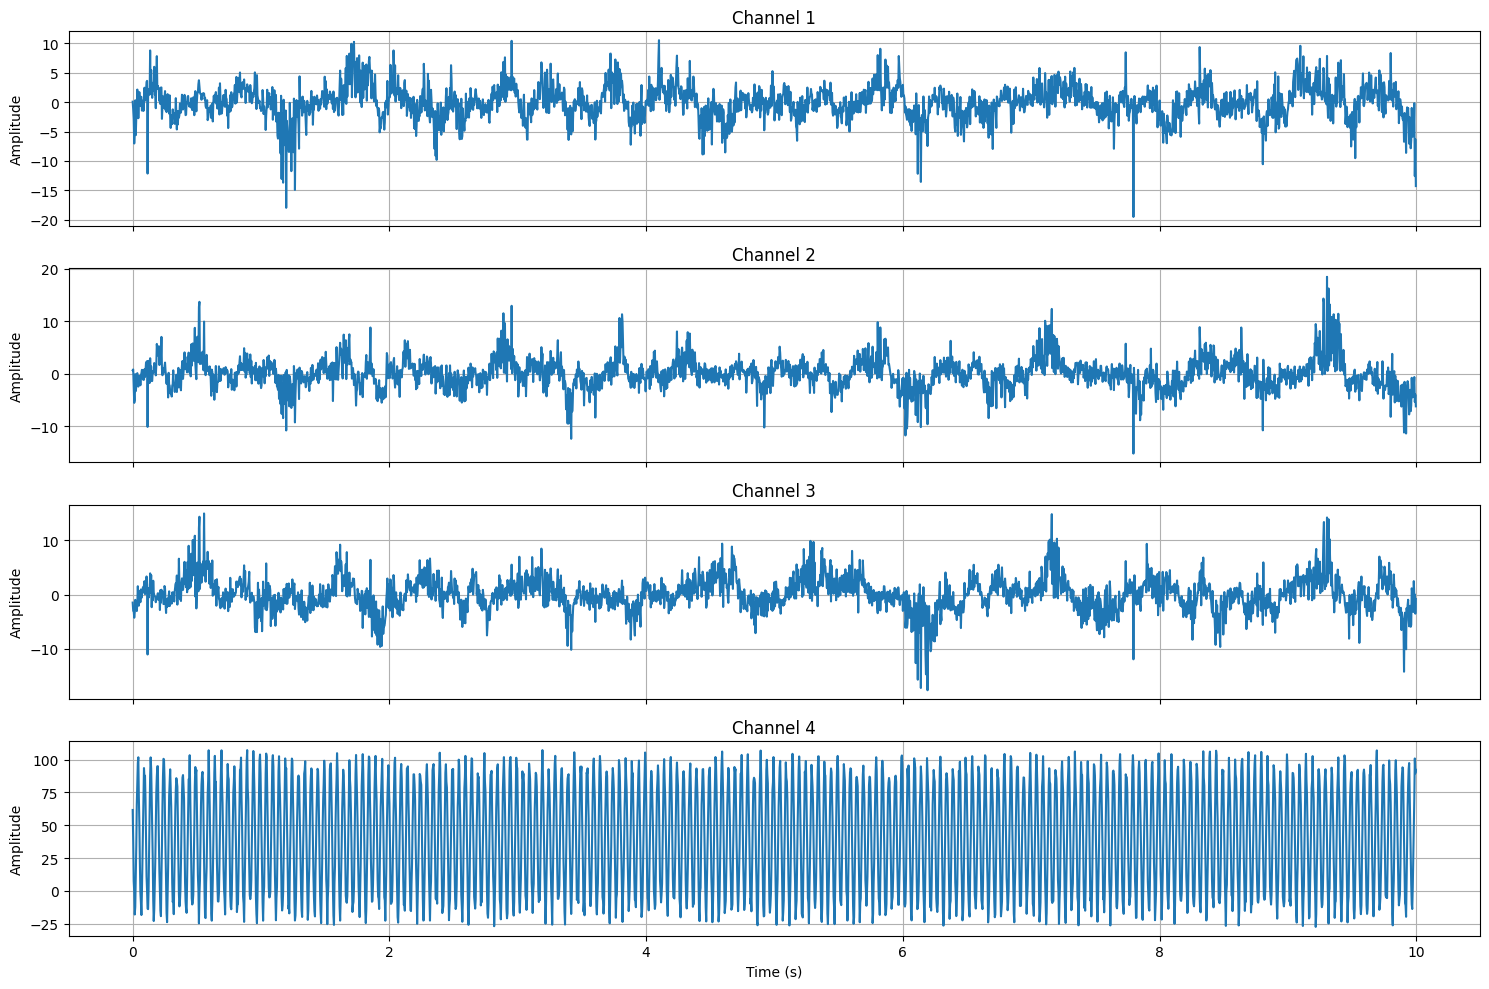

In [6]:
import matplotlib.pyplot as plt

samples_per_second = 250
num_channels=4 # how many you want to plot
    
time = np.arange(data.shape[1]) / samples_per_second
fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

if num_channels == 1:
    axes = [axes]

for i, ax in enumerate(axes[:num_channels]):
    ax.plot(time, data[i])
    ax.set_title(f'Channel {i+1}')
    ax.set_ylabel('Amplitude')
    ax.grid(True)

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

We passed 'focus' as parameter of the dummy EEG generator. This implies the following amplitude proportions:     
```   
            del  the  alp  bet  gam
'focus':   [0.1, 0.1, 0.5, 0.8, 0.4]
```
Is it what we find in the signal if we perform a PSD?

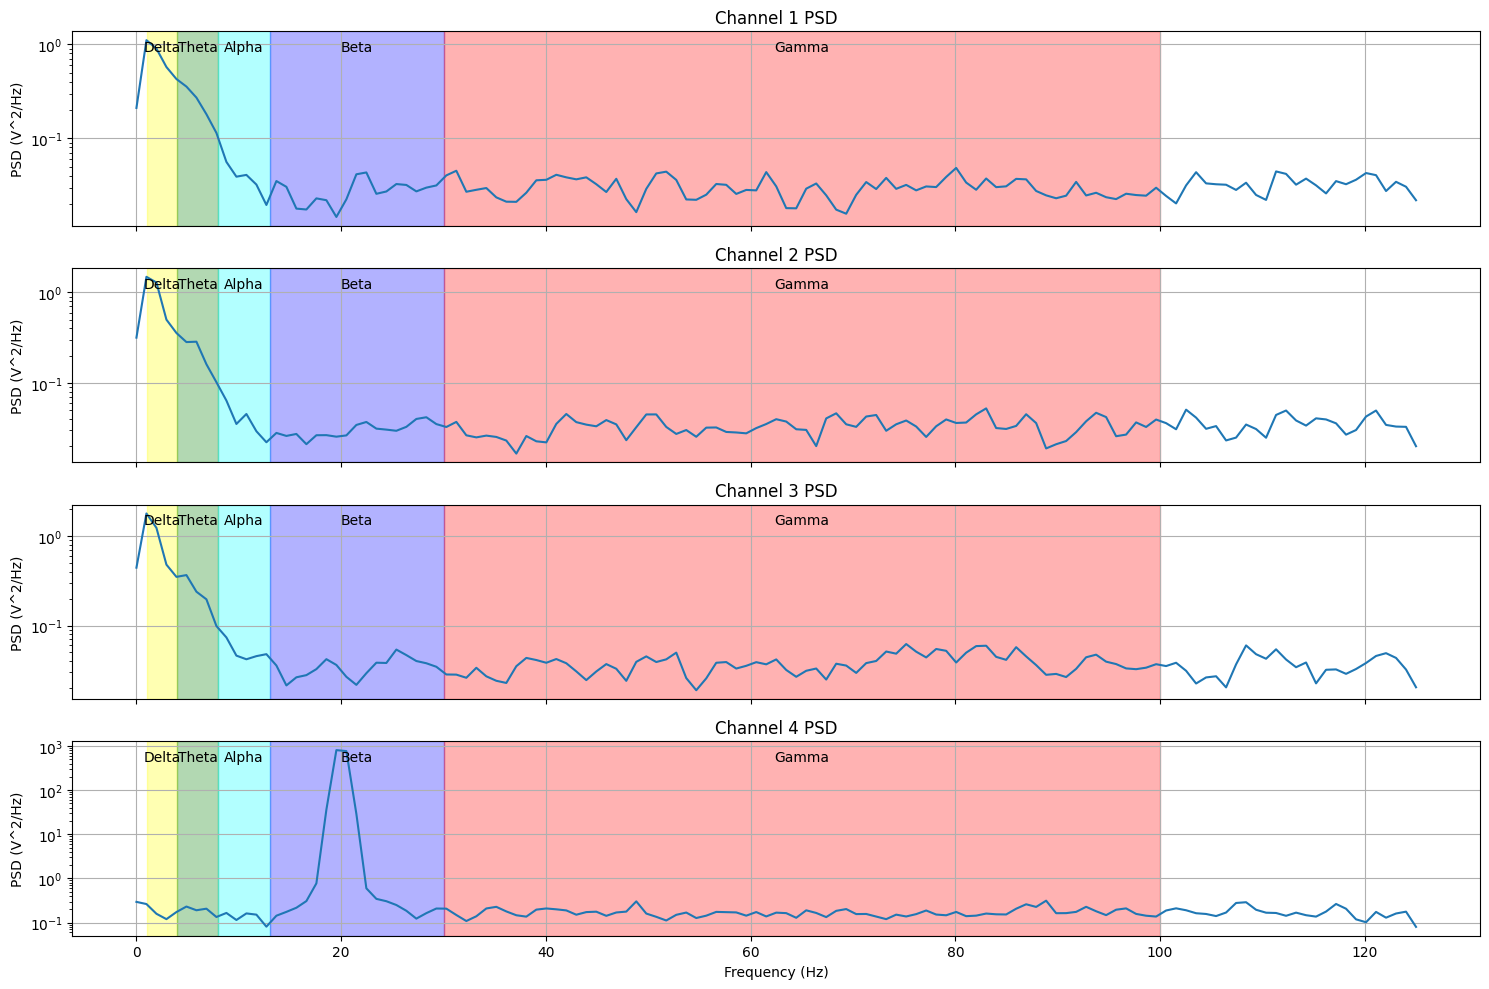

In [7]:
from scipy import signal

# Define frequency bands
bands = {
    'Delta': (1, 4, 'yellow'),
    'Theta': (4, 8, 'green'),
    'Alpha': (8, 13, 'cyan'),
    'Beta': (13, 30, 'blue'),
    'Gamma': (30, 100, 'red')
}

fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

if num_channels == 1:
    axes = [axes]

for i in range(num_channels):
    # Plotting the PSD
    freqs, psd = signal.welch(data[i], fs=samples_per_second)
    axes[i].semilogy(freqs, psd)
    axes[i].set_title(f'Channel {i+1} PSD')
    axes[i].set_ylabel('PSD (V^2/Hz)')
    axes[i].grid(True)

    # Highlighting frequency bands
    for band, (low, high,col) in bands.items():
        axes[i].axvspan(low, high, color=col, alpha=0.3)
        axes[i].text((low + high) / 2, max(psd), band, horizontalalignment='center', verticalalignment='top')

axes[-1].set_xlabel('Frequency (Hz)')
plt.tight_layout()
plt.show()